# CPSC 536M - Homework 2
Emma Hansen and Naomi Graham

October 2020

In [2]:
# Load packages
using Images, FileIO, ImageMagick, Zygote, Random, LinearAlgebra, Colors, DSP,ToeplitzMatrices, SparseArrays, Wavelets, LazySets
#using PyPlot, FFTW, ForwardDiff

## Frank-Wolfe Algorithm

In [3]:
# Frank-Wolfe
function frank_wolfe(tau,f,f_grad,K,x0_wav,wav)
    # x0 is a vector
    n = size(x0_wav)[1]
    
    for k=1:K
        x0 = idwt(x0_wav, wav, 3)
        grad_f = f_grad(x0)
        ind_max = argmax(grad_f)
        #exact minimization (as opposed in inexact variant of Frank-Wolfe)
        s = -tau * sign(grad_f[ind_max])* I(n)[:,ind_max] # from http://www.stat.cmu.edu/~ryantibs/convexopt-S15/scribes/23-cond-grad-scribed.pdf
        
        gamma = 2 / (2+k) # not using line search
        x1_wav = ((1-gamma) .* x0_wav) + (gamma .* s)
        x0_wav = deepcopy(x1_wav)
        #x_history[:,k+1] = x0
        
        # for checking progress
        if mod(k,100)==0
            print("k is: ")
            println(k)
            print("the function value is: ")
            println(f(idwt(x0_wav, wav, 3)))
        end
    end
    return x0_wav
end

frank_wolfe (generic function with 1 method)

## Define helper functions

In [4]:
# define a function to calculate the objective value

function objective(X_vec,R,B_vec)
# X = idwt(X_wav, wav, 3) # commented out since derivative doesn't like the transform to occur in the objective...
    return (1/2) * sum(( (R * X_vec) - B_vec) .^ 2)
end

##
function obejctive_gradient(X_vec,R,B_vec,wav)
    #gradfx = gradient(y -> objective(y,R,B_vec) , X_vec) # too slow
    #return dwt(gradfx[1], wav, 3) # too slow 
    return dwt((R' * R * X_vec) - (R' * B_vec), wav, 3)
end

# convolution function
function ConvolutionMatrix(Kernel,N)
    # N is length of image to be convolved with (must be a square image)
    toeplitzrow = hcat(Kernel[1,:]',zeros(1,N-size(Kernel)[1]))
    for i=2:size(Kernel)[1]
        toeplitzrow = hcat(toeplitzrow,Kernel[i,:]',zeros(1,N-size(Kernel)[1]))
    end
    l = size(toeplitzrow)[2]
    toeplitzrow = hcat(toeplitzrow,zeros(1,N^2-l))

    toeplitz = Circulant(toeplitzrow')'
    
    return sparse(toeplitz)
end

ConvolutionMatrix (generic function with 1 method)

## Loading images

In [5]:
# Clear image
original_path = "smaller_climber128.jpg"
original = load(original_path)
original_grey = Gray.(original)
original_array = convert(Array{Float64}, original_grey)
n, = size(original_array)

(128, 128)

In [6]:
# Blurring in photoshop
blurry_path = "smaller_climber_blurry.jpg"
blurry1 = load(blurry_path)
blurry_grey = Gray.(blurry1)
blurry1_array = convert(Array{Float64}, blurry_grey)

128×128 Array{Float64,2}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  0.0         0.0         0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0     0.0         0.0         0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0     0.0         0.0         0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0     0.0         0.0         0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0     0.0         0.0         0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  0.0         0.0         0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0     0.0         0.0         0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0     0.0         0.0         0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0     0.0         0.0         0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0     0.0         0.0         0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  0.0         0.0         0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0     0.0         0.0         0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0     0.0         0.0         0.0
 ⋮                        ⋮         ⋱  ⋮                       
 1.0  1.0  1.0  1.0  1.0  1.0  1.0     

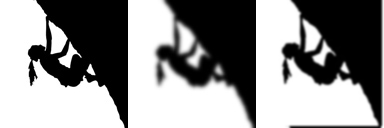

In [7]:
# Blurring in Julia
Kernel = (1/256) .* [1 4 6 4 1; 4 16 24 16 4; 6 24 36 24 6; 4 16 24 16 4; 1 4 6 4 1]
m = size(Kernel)[1]
conv_matrix = ConvolutionMatrix(Kernel,n)
blurry_array = reshape(conv_matrix * original_array[:],size(original_array))


mosaicview(original, blurry1, Gray.(blurry_array); nrow=1)

## Set parameters and initial values

In [9]:
#max iteration parameter K
K = 5001 # frank-wolfe iterations
wt = wavelet(WT.haar) # define wavelet to use in transform
wt = WT.scale(wt, 1) # 1/sqrt(2) scales output to be between 0 and 1 - useful? idk


# define B
BLURRY = blurry_array

# take wave transform of blurry image for starting point
X0_wav = dwt(BLURRY,wt,3)


2000

## Define functions with fixed parameters from data

In [10]:
# defining objective for input data
f = (y -> objective(y,conv_matrix,BLURRY[:]))

# defining gradient for input data
f_grad = (y -> obejctive_gradient(y,conv_matrix,BLURRY[:],wt))

#3 (generic function with 1 method)

## Run the algorithm!
### start with $\tau = 2000$

We computed the one-norm of the wavelet transform of the input blurry image to be around 1800. We think it wouldn't make sense to try to restrict ourselves to a smaller tau than the one-norm of the input. For this reason we start with 2000, then try 4000, with marginally better results. Finally we try 1000 and see the results are a little worse.

In [11]:
# parameter 
#tau = 1800 # make tau > the 1-norm of the wavelet transform of blurry matrix


tau = 2000 # make tau > the 1-norm of the wavelet transform of blurry matrix


X_wav_sol = frank_wolfe(tau,f,f_grad,K,X0_wav[:],wt); # call frank-wolfe
X_sol = idwt(X_wav_sol, wt, 3); # inverse wavelet transform to bring back to the image domain

k is: 100
the function value is: 4968.045341035567
k is: 200
the function value is: 4636.403075066889
k is: 300
the function value is: 4488.457820706344
k is: 400
the function value is: 4445.925657718278
k is: 500
the function value is: 4391.4750231390435
k is: 600
the function value is: 4332.653703475817
k is: 700
the function value is: 4285.8877987241085
k is: 800
the function value is: 4253.076223121322
k is: 900
the function value is: 4241.625589579849
k is: 1000
the function value is: 4230.0016235841795
k is: 1100
the function value is: 4218.60026009545
k is: 1200
the function value is: 4213.101890960859
k is: 1300
the function value is: 4208.93863174899
k is: 1400
the function value is: 4205.154513319861
k is: 1500
the function value is: 4202.537403392873
k is: 1600
the function value is: 4200.651716587159
k is: 1700
the function value is: 4197.618527015264
k is: 1800
the function value is: 4195.783200607605
k is: 1900
the function value is: 4195.443823857732
k is: 2000
the funct

With $\tau = 2000$, we converge the value $~4181$ in $5000$ iterations

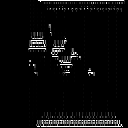

In [15]:
X = reshape(X_sol,size(blurry_array))
Gray.(X)

The progress slows considerably after a few hundred iterations. We aren't sure we computed the gradient correctly so that could be why we are getting poor results even after many iterations.

### $\tau = 4000$

In [16]:
tau = 4000 # make tau >> the 1-norm of the wavelet transform of blurry matrix


X_wav_sol2 = frank_wolfe(tau,f,f_grad,K,X0_wav[:],wt); # call frank-wolfe
X_sol2 = idwt(X_wav_sol, wt, 3); # inverse wavelet transform to bring back to the image domain

k is: 100
the function value is: 5980.91819089248
k is: 200
the function value is: 5595.598137037452
k is: 300
the function value is: 5118.993156621917
k is: 400
the function value is: 4828.847651715543
k is: 500
the function value is: 4678.565644657584
k is: 600
the function value is: 4611.787159978008
k is: 700
the function value is: 4548.791933273868
k is: 800
the function value is: 4519.553843125821
k is: 900
the function value is: 4492.690557129634
k is: 1000
the function value is: 4454.608476821892
k is: 1100
the function value is: 4373.459561512974
k is: 1200
the function value is: 4296.4597249719445
k is: 1300
the function value is: 4271.209699475559
k is: 1400
the function value is: 4249.393999062821
k is: 1500
the function value is: 4233.023101232023
k is: 1600
the function value is: 4224.356628615193
k is: 1700
the function value is: 4207.591657402256
k is: 1800
the function value is: 4195.8279857608295
k is: 1900
the function value is: 4184.149903056359
k is: 2000
the funct

With $\tau = 4000$, we converge the value $4100$ in $5000$ iterations

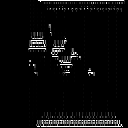

In [17]:
X2 = reshape(X_sol2,size(blurry_array))
Gray.(X2)


### $\tau = 1000$




In [18]:
tau = 1000 # make tau < the 1-norm of the wavelet transform of blurry matrix


X_wav_sol3 = frank_wolfe(tau,f,f_grad,K,X0_wav[:],wt); # call frank-wolfe
X_sol3 = idwt(X_wav_sol, wt, 3); # inverse wavelet transform to bring back to the image domain

k is: 100
the function value is: 4530.5966416371375
k is: 200
the function value is: 4393.611514916474
k is: 300
the function value is: 4339.287856024588
k is: 400
the function value is: 4304.294513463505
k is: 500
the function value is: 4284.01288879807
k is: 600
the function value is: 4273.152571429477
k is: 700
the function value is: 4266.255026423586
k is: 800
the function value is: 4262.53367483247
k is: 900
the function value is: 4261.7348558904705
k is: 1000
the function value is: 4258.896321277756
k is: 1100
the function value is: 4258.001681377067
k is: 1200
the function value is: 4256.833513507501
k is: 1300
the function value is: 4256.020893110119
k is: 1400
the function value is: 4255.1907514706945
k is: 1500
the function value is: 4254.610808720317
k is: 1600
the function value is: 4254.305457792411
k is: 1700
the function value is: 4253.773588937267
k is: 1800
the function value is: 4253.43157314816
k is: 1900
the function value is: 4253.4095132679595
k is: 2000
the funct

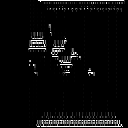

In [19]:
X3 = reshape(X_sol3,size(blurry_array))
Gray.(X3)

# some code we tried but didn't end up using

## Line Search function (not using)

In [ ]:
# defining line search function

function linesearch(grad_f,s,d)
    #alpha_upper0 = 1
    #alpha_lower0 = 0
    alpha_mid = 0.5
    alpha_range = 0.5
    stop = 50
    alpha_storage = zeros(stop+1)
    alpha_storage[1] = alpha_mid
    
    for i=1:stop
        val_mid = dot(-grad_f, alpha_mid * s + (1-alpha_mid) * d) / (norm(grad_f)*norm(alpha_mid * s + (1-alpha_mid) * d))
        alpha_upper = alpha_mid + (1/2)*alpha_range
        alpha_lower = alpha_mid - (1/2)*alpha_range
        
        val_upper = dot(-grad_f, alpha_upper * s + (1-alpha_upper) * d) / (norm(grad_f)*norm(alpha_upper * s + (1-alpha_upper) * d))
        val_lower = dot(-grad_f, alpha_lower * s + (1-alpha_lower) * d) / (norm(grad_f)*norm(alpha_lower * s + (1-alpha_lower) * d))
        
        if val_upper > val_mid # note: I think something is wrong with this criteria...
            alpha_mid = deepcopy(alpha_upper)
        elseif val_lower > val_mid
            alpha_mid = deepcopy(alpha_lower)
        end
        
        alpha_range = (1/2) * alpha_range
        alpha_storage[i+1] = deepcopy(alpha_mid)
    end
    return alpha_mid, alpha_storage
end



## atomic iterate search (not using) 

In [ ]:
# to solve <s,grad(f)>
function get_s(D,grad_f) # works if you know the atoms
    n,m = size(D)
    stop = 100
    
    IP = ((-grad_f)' * D) ./ (norm(grad_f) .* 1)
    ind_max = argmax(IP)[2]
    s0 = D[:,ind_max]
    val0 = maximum(IP)

    IP_new = deepcopy(IP)
    IP_new[ind_max] = -IP[ind_max]
    
    max_inds = zeros((m,1))
    max_inds[1] = ind_max
    
    for j=2:m
        ind_max = argmax(IP_new)[2]
        d = D[:,ind_max]
        
        alpha, = linesearch(grad_f,s0,d)
        s1 = alpha * s0 + (1-alpha) * d
        
        val1 = (s1' * (-grad_f))[1]
        
        if val1 < val0
            return s0,max_inds
            break
        end
        
        s0 = s1
        IP_new[ind_max] = -IP[ind_max]
        val0 = val1
        max_inds[j] = ind_max
    end
end
        
function get_s(grad_f,tau)
    eps = 0.01
    n = size(grad_f)[1]
    s0 = rand(n)
    s0 = tau .* (s0 ./ sum(x0))
    
    while (s0' * (-grad_f)) > eps
        d = rand(n)
        d = tau .* (d ./ sum(d))
        
        alpha, = linesearch(grad_f,s0,d)
        s1 = alpha .* s0 + (1-alpha) .* d
        
    end
    
end